### 图像情感分类(Image Sentiment Classification)

+ 任务描述：https://ntumlta.github.io/ML-Assignment3/index.html
+ PPT：https://docs.google.com/presentation/d/1txLnBXLYmpJOMsDJItB81lA1gHJ21fgnZTxXWZtgryE/edit#slide=id.p2
+ 数据集：https://drive.google.com/file/d/1UGM_CJkNb7OmUQKpxSmaUETiCQd_OBus/view

#### 1.任务需求

+ 建立卷积神经网络
    + 建立CNN模型，并尽可能将其调到最佳状态。
    + 记录您的模型结构和培训程序。
+ 建立深度神经网络
    + 使用与上述CNN相同数量的参数，构建一个DNN模型来完成这项任务。
    + 记录您的模型结构和培训程序。解释你所观察到的。
+ 用混淆矩阵分析模型
    + 观察验证数据的预测（10%~20%的培训数据可以）。
    + 将预测绘制成混淆矩阵，并描述所观察到的情况。
+ 绘制显著性图分析模型
    + 绘制原始图像的显著性图，以确定在分类时哪个部分是重要的。
+ 可视化分析模型
    + 使用类中提到的渐变上升方法查找激活所选过滤器最多的图像并绘制它们。
    
参考：https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

#### 2.数据集描述

+ 训练集
本次作业为图像情感分类(Image Sentiment Classification)。我们提供给各位的训练集为2万8千张左右48x48的图片和每一张图片的label。（每一张图片只属于一种表情）<br>
总共有七种可能的表情  0：生气, 1：厌恶, 2：恐惧, 3：高兴, 4：难过, 5：惊讶, 6：中立(除前6种以外的表情)

+ 测试集
测试集为7000张左右的48x48的图片，利用训练集训练一个 CNN 模型，预测出每一张图片的表情 label 并保存在 csv 文件中。 

#### 3.数据清洗与分析 

使用 pandas, numpy 等工具将原始数据 train.csv 进行处理分析, 将 feature 以 shape(48,48), 将 label 以一维 np.array 的格式输出

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# 训练集
name = ['angry','disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
train_filename = "HW03/train.csv"
train_df = pd.read_csv(train_filename)
train_df.shape

(28709, 2)

In [3]:
# 数据集前5行具体内容
train_df.head()

,label,feature
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
# 测试集
train_filename = "HW03/test.csv"
test_df = pd.read_csv(train_filename)
test_df.shape

(7178, 2)

In [5]:
test_df.head()

,id,feature
0,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,1,156 184 198 202 204 207 210 212 213 214 215 21...
2,2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


### 获取训练集的标签以及每个标签所具有的数据集

In [6]:
train_df['label'].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: label, dtype: int64

|angry|disgust|	fear|	happy|	sad|	surprise|	neutral|
|--|--|--|--|--|--|--|
|3995|	436|	4097|	7215|	4830|	3171|	4965|

### 绘制图片

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    name = ['angry','disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    assert len(images) == len(cls_true) == 9

    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Get the i'th image and reshape the array.

        image = images[i].reshape(48, 48)

        # Ensure the noisy pixel-values are between 0 and 1.
        # image = np.clip(image, 0.0, 1.0)

        # Plot image.
        ax.imshow(image,
                  cmap='gray',
                  interpolation='nearest')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True:{0}".format(name[cls_true[i]])
        else:
            xlabel = "True:{0}, Pred:{1}".format(name[cls_true[i]], name[cls_pred[i]])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 清洗数据类

In [8]:
class clean_data(object):
    _train = True

    def __init__(self, filename, train=True):
        self._train = train
        self._train_df = pd.read_csv(filename)
        self._train_df['feature'] = self._train_df['feature'].map(lambda x: np.array(list(map(float, x.split()))))
        self._image_size = self._train_df.feature[0].size
        self._image_shape = (int(np.sqrt(self._image_size)), int(np.sqrt(self._image_size)))
        self._dataNum = self._train_df.size
        self._feature = np.array(self._train_df.feature.map(lambda x: x.reshape(self._image_shape)).values.tolist())
        if self._train:
            self._label = self._train_df.label.values
            self._labelNum = self._train_df['label'].unique().size
            self._onehot = pd.get_dummies(self._train_df.label).values

    @property
    def distribution(self):
        return self._distribution

    @property
    def image_size(self):
        return self._image_size

    @property
    def image_shape(self):
        return self._image_shape

    @property
    def dataNum(self):
        return self._dataNum

    @property
    def feature(self):
        return self._feature

    if _train:
        @property
        def label(self):
            return self._label

        @property
        def labelNum(self):
            return self._labelNum

        @property
        def onehot(self):
            return self._onehot

### 获取清洗后的数据

In [9]:
data = clean_data('HW03/train.csv')
data

In [10]:
# 数据标签 数目
data.labelNum

7

In [11]:
# 数据标签
data.label

array([0, 0, 2, ..., 4, 0, 4], dtype=int64)

In [12]:
# 数据标签
a = pd.read_csv('HW03/train.csv')['label']
a.head()

0    0
1    0
2    2
3    4
4    6
Name: label, dtype: int64

In [13]:
# 每个标签的具体内容
sample_images = [list(a[a == x].index)[0:9] for x in range(data.labelNum)]
sample_images

[[0, 1, 10, 22, 23, 27, 38, 40, 43],
 [299, 388, 416, 473, 533, 573, 758, 807, 826],
 [2, 5, 9, 17, 21, 33, 45, 48, 49],
 [7, 8, 14, 16, 24, 25, 28, 30, 32],
 [3, 6, 19, 20, 42, 54, 58, 63, 66],
 [15, 26, 29, 39, 51, 52, 55, 61, 69],
 [4, 11, 12, 13, 18, 31, 35, 36, 37]]

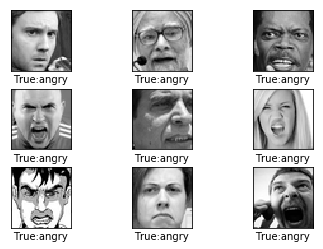

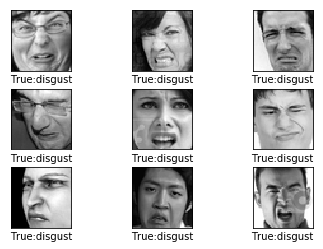

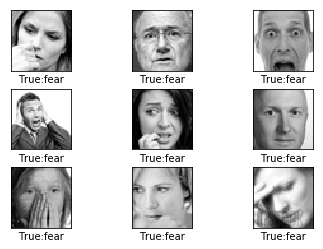

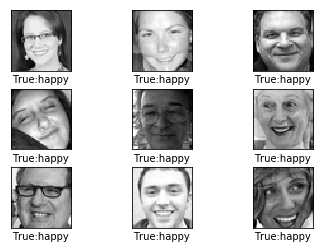

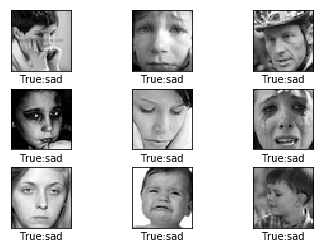

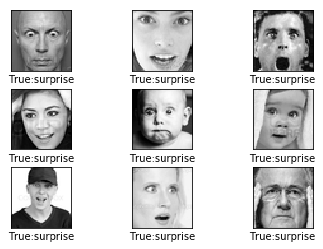

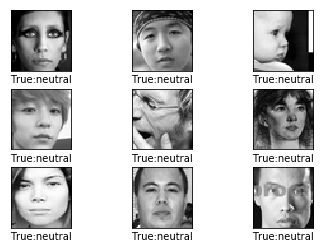

In [14]:
for x in sample_images:
    plot_images(data.feature[x], data.label[x])

0


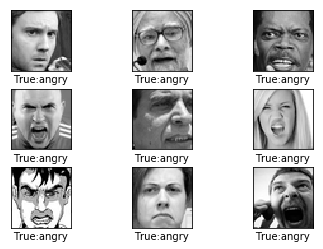

1


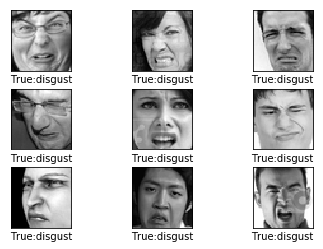

2


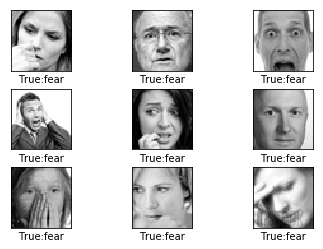

3


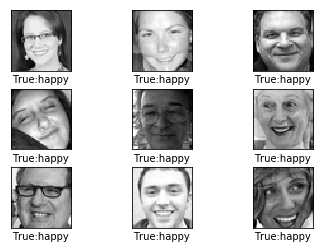

4


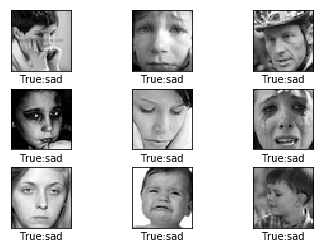

5


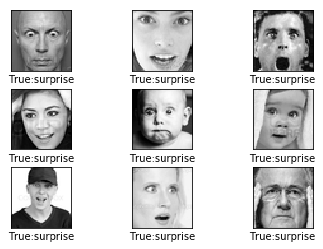

6


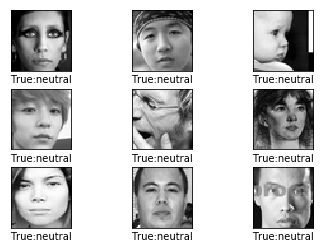

In [15]:
for i,x in enumerate(sample_images):
    print(i)
    plot_images(data.feature[x], data.label[x])

#### 4.建立模型

#### 4.1 后续可能用到的工具

In [16]:
import pandas as pd
import numpy as np
from time import time
from matplotlib import pyplot as plt

def plot_training_history(r):
    # plot some data
    plt.plot(r.history['loss'], label='loss')
    plt.plot(r.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

    # accuracies
    plt.plot(r.history['acc'], label='acc')
    plt.plot(r.history['val_acc'], label='val_acc')
    plt.legend()
    plt.show()

#### 4.2 CNN模型

Train on 26709 samples, validate on 2000 samples
Epoch 1/100
26709/26709 [==============================] - 32s 1ms/step - loss: 1.6311 - acc: 0.3907 - val_loss: 1.7717 - val_acc: 0.2730
Epoch 2/100
26709/26709 [==============================] - 32s 1ms/step - loss: 1.3622 - acc: 0.4925 - val_loss: 1.4816 - val_acc: 0.4440
Epoch 3/100
26709/26709 [==============================] - 30s 1ms/step - loss: 1.2338 - acc: 0.5414 - val_loss: 1.3379 - val_acc: 0.4955
Epoch 4/100
26709/26709 [==============================] - 30s 1ms/step - loss: 1.1467 - acc: 0.5746 - val_loss: 1.1779 - val_acc: 0.5545
Epoch 5/100
26709/26709 [==============================] - 30s 1ms/step - loss: 1.0621 - acc: 0.6081 - val_loss: 1.2266 - val_acc: 0.5380
Epoch 6/100
26709/26709 [==============================] - 30s 1ms/step - loss: 0.9854 - acc: 0.6341 - val_loss: 1.1497 - val_acc: 0.5765
Epoch 7/100
26709/26709 [==============================] - 54s 2ms/step - loss: 0.9072 - acc: 0.6695 - val_loss: 1.1526 - v

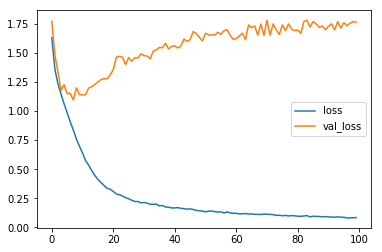

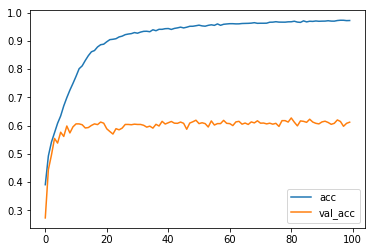

In [52]:
import pandas as pd
import numpy as np
from time import time
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.models import Model

from sklearn.utils.class_weight import compute_class_weight

name = ['angry','disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

train_data = clean_data('HW03/train.csv')
test_data = clean_data('HW03/test.csv', False)

train = train_data.feature.reshape((-1, 48, 48, 1))/255
train_x = train[:-2000]
train_label = train_data.label[:-2000]
train_onehot = train_data.onehot[:-2000]
test_x = train[-2000:]
test_label = train_data.label[-2000:]
test_onehot = train_data.onehot[-2000:]


class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(train_data.label),
                                    y=train_data.label)


#CNN model

inputs = Input(shape=(48,48,1))

# First convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=64, padding='same',
             activation='relu', name='layer_conv1')(inputs)
net = MaxPooling2D(pool_size=2, strides=2)(net)
net = BatchNormalization(axis = -1)(net)
net = Dropout(0.25)(net)

# Second convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=128, padding='same',
             activation='relu', name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)
net = BatchNormalization(axis = -1)(net)
net = Dropout(0.25)(net)

# Third convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=256, padding='same',
             activation='relu', name='layer_conv3')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)
net = BatchNormalization(axis = -1)(net)
net = Dropout(0.5)(net)

# Flatten the output of the conv-layer from 4-dim to 2-dim.
net = Flatten()(net)

# First fully-connected / dense layer with ReLU-activation.
net = Dense(128)(net)
net = BatchNormalization(axis = -1)(net)
net = Activation('relu')(net)

# Last fully-connected / dense layer with softmax-activation
# so it can be used for classification.
net = Dense(7)(net)
net = BatchNormalization(axis = -1)(net)
net = Activation('softmax')(net)
# Output of the Neural Network.
outputs = net
model = Model(inputs=inputs, outputs=outputs)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.compile(optimizer='Adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
y = model.fit(x=train_x,
           y=train_onehot,
           validation_data=(test_x, test_onehot),
           class_weight=class_weight,
           epochs=100, batch_size=64,
           callbacks=[tensorboard]
             )

plot_training_history(y)
#
model.save('cnn.h5')

#### 4.3 DNN 模型

Train on 26709 samples, validate on 2000 samples
Epoch 1/100
26709/26709 [==============================] - 9s 344us/step - loss: 1.8126 - acc: 0.3044 - val_loss: 1.8730 - val_acc: 0.2645
Epoch 2/100
26709/26709 [==============================] - 8s 297us/step - loss: 1.6474 - acc: 0.3686 - val_loss: 1.7269 - val_acc: 0.2780
Epoch 3/100
26709/26709 [==============================] - 8s 294us/step - loss: 1.5834 - acc: 0.3873 - val_loss: 1.6386 - val_acc: 0.3520
Epoch 4/100
26709/26709 [==============================] - 8s 297us/step - loss: 1.5408 - acc: 0.4074 - val_loss: 1.7676 - val_acc: 0.2940
Epoch 5/100
26709/26709 [==============================] - 8s 293us/step - loss: 1.5064 - acc: 0.4183 - val_loss: 1.5821 - val_acc: 0.3890
Epoch 6/100
26709/26709 [==============================] - 8s 288us/step - loss: 1.4750 - acc: 0.4336 - val_loss: 1.7199 - val_acc: 0.2760
Epoch 7/100
26709/26709 [==============================] - 8s 285us/step - loss: 1.4511 - acc: 0.4411 - val_loss: 1.7

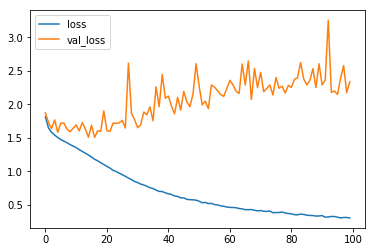

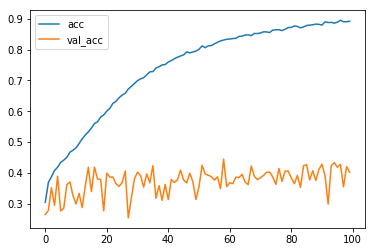

In [53]:
#DNN model
import pandas as pd
import numpy as np
from time import time
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.models import Model

from sklearn.utils.class_weight import compute_class_weight

name = ['angry','disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

train_data = clean_data('HW03/train.csv')
test_data = clean_data('HW03/test.csv', False)

train = train_data.feature.reshape((-1, 48, 48, 1))/255
train_x = train[:-2000]
train_label = train_data.label[:-2000]
train_onehot = train_data.onehot[:-2000]
test_x = train[-2000:]
test_label = train_data.label[-2000:]
test_onehot = train_data.onehot[-2000:]


class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(train_data.label),
                                    y=train_data.label)


inputs = Input(shape=(48,48,1))

dnn = Flatten()(inputs)

dnn = Dense(512)(dnn)
dnn = BatchNormalization(axis = -1)(dnn)
dnn = Activation('relu')(dnn)
dnn = Dropout(0.25)(dnn)

dnn = Dense(1024)(dnn)
dnn = BatchNormalization(axis = -1)(dnn)
dnn = Activation('relu')(dnn)
dnn = Dropout(0.5)(dnn)

dnn = Dense(512)(dnn)
dnn = BatchNormalization(axis = -1)(dnn)
dnn = Activation('relu')(dnn)
dnn = Dropout(0.5)(dnn)

dnn = Dense(7)(dnn)
dnn = BatchNormalization(axis = -1)(dnn)
dnn = Activation('softmax')(dnn)

outputs = dnn

model2 = Model(inputs=inputs, outputs=outputs)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model2.compile(optimizer='Adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

d = model2.fit(x=train_x,
           y=train_onehot,
           validation_data=(test_x, test_onehot),
           class_weight=class_weight,
           epochs=100, batch_size=64,
           callbacks=[tensorboard]
             )

plot_training_history(d)
model2.save('dnn.h5')

### 5.结果报告

#### 5.1 创建CNN

In [22]:
from tensorflow.python.keras.models import load_model
cnn = load_model('cnn.h5')
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 48, 48, 64)        1664      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 24, 24, 128)       204928    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 128)       0         
__________

CNN的结构如图所示, 主要有3个conv box以及在flatten后接一个dense_layer, 每一个conv box里面由convolution_layer, batch_normalization, max_pool, dropout构成, 所有Conv2D中kernel_size=5, strides=1, MaxPooling2D中pool_size=2, strides=1, 除了最后一层为softmax, 其他所有层的activation均为relu, Total params: 2,209,059, Trainable params: 2,207,893, Non-trainable params: 1,166

训练过程中accuracy与loss变化如下图所示

![](http://imgbed.momodel.cn/HW03CNN01.png)![](http://imgbed.momodel.cn/HW03CNN02.png)

#### 5.2 创建DNN

In [23]:
from tensorflow.python.keras.models import load_model
dnn = load_model('dnn.h5')
dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1180160   
_________________________________________________________________
batch_normalization_15 (Batc (None, 512)               2048      
_________________________________________________________________
activation_6 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
__________

![](http://imgbed.momodel.cn/dnn.png)

DNN有三层Dense_layer构成, 每层的数目分别为512, 1024, 512, 每层后面均有batch_normalization和dropout, activation同样为relu,Total params: 2,242,083, Trainable params: 2,237,973, Non-trainable params: 4,110 训练过程中accuracy与loss变化如下

![](http://imgbed.momodel.cn/HW03DNN01.png)![](http://imgbed.momodel.cn/HW03DNN02.png)

+ 比较


在可训练参数数目相差不多的情况下, dnn每一个epoch的训练时间约为4s, 远快于cnn的19s, 但是在同样做了BN以及droupout的情况下, cnn的训练效果远好于dnn.



在验证集为数据集最后2000笔的情况下, cnn在验证集的正确率达到了60%, 而dnn只有40%, 证明了课上的理论, cnn能够更高效的利用每一个参数

#### 5.3 混淆矩阵

In [24]:
# 导入相关包
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.models import load_model
import math

In [25]:
classes = ['angry','disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [26]:
# 绘制混淆矩阵
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [27]:
# 数据处理
train_data = clean_data('train.csv')
train = train_data.feature.reshape((-1, 48, 48, 1))/255
train_x = train[:-2000]
train_label = train_data.label[:-2000]
train_onehot = train_data.onehot[:-2000]
test_x = train[-2000:]
test_label = train_data.label[-2000:]
test_onehot = train_data.onehot[-2000:]

In [28]:
# 加载模型
cnn = load_model('cnn.h5')
dnn = load_model('dnn.h5')


In [29]:
# CNN 测试集预测值
cnn_predict = cnn.predict(test_x)
cnn_predict


array([[4.4511249e-03, 8.9447012e-06, 3.6505731e-03, ..., 1.4194774e-02,
        2.5332156e-06, 3.5592529e-06],
       [9.9379756e-02, 2.3491585e-03, 8.7135249e-01, ..., 8.0819363e-03,
        6.0006144e-04, 9.3898521e-04],
       [5.4206412e-05, 1.3496800e-05, 3.3257729e-03, ..., 9.9521697e-01,
        2.5776742e-04, 1.0964699e-03],
       ...,
       [1.5202332e-01, 5.9246930e-04, 1.9844148e-04, ..., 8.4696233e-01,
        3.4184407e-06, 7.0966646e-09],
       [2.5259323e-02, 1.3896416e-01, 1.6798109e-02, ..., 1.3306390e-01,
        4.7835682e-02, 4.8400789e-01],
       [1.7314930e-02, 5.2077738e-03, 7.4914312e-01, ..., 1.9371387e-01,
        2.6394090e-02, 4.1387691e-03]], dtype=float32)

In [30]:
# 返回每一行的最大值
cnn_cls = np.argmax(cnn_predict, axis=1)
cnn_cls

array([3, 2, 4, ..., 4, 6, 2], dtype=int64)

In [31]:
# 深度学习 测试集预测值
dnn_predict = dnn.predict(test_x)
dnn_predict

array([[4.50726062e-01, 8.82061373e-04, 5.47709968e-03, ...,
        1.91200837e-01, 1.13421695e-04, 2.92558596e-03],
       [3.51056978e-02, 1.36938936e-04, 8.97028223e-02, ...,
        7.56951511e-01, 5.07562794e-03, 2.75679622e-02],
       [5.61937332e-01, 1.11836125e-03, 1.60372630e-02, ...,
        3.78281325e-01, 6.04060013e-04, 4.01267298e-02],
       ...,
       [6.25315905e-02, 1.03670776e-04, 8.16022009e-02, ...,
        8.54544163e-01, 2.03218282e-04, 4.57794435e-04],
       [1.60742268e-01, 1.39941741e-03, 3.08628799e-03, ...,
        6.43366352e-02, 1.37863960e-02, 7.11973429e-01],
       [3.49388242e-01, 6.72818068e-03, 5.92520833e-01, ...,
        2.51918603e-02, 1.71936899e-02, 1.51414250e-03]], dtype=float32)

In [32]:
dnn_cls = np.argmax(dnn_predict, axis=1)
dnn_cls

array([0, 4, 0, ..., 4, 6, 2], dtype=int64)

Confusion matrix, without normalization
[[163   1  21  26  38   6  51]
 [  4  11   1   4   2   2   0]
 [ 29   0 132   6  52  16  24]
 [  6   1   9 425  16  12  42]
 [ 22   0  44  31 164   4  62]
 [ 12   0  20  15   8 165  17]
 [ 30   0  32  33  67  10 164]]


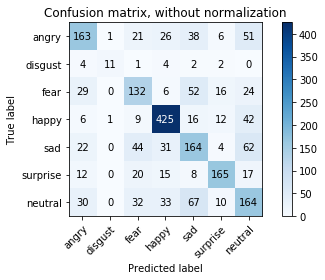

In [33]:
# CNN 的混淆矩阵
plot_confusion_matrix(test_label, cnn_cls, classes)

Confusion matrix, without normalization
[[153   0  32  42  49   2  28]
 [ 11   1   2   5   2   2   1]
 [ 90   0  65  29  45   7  23]
 [ 99   0  38 273  57   6  38]
 [ 86   0  43  34 127   6  31]
 [ 62   0  23  21  19  91  21]
 [ 96   0  28  57  59   2  94]]


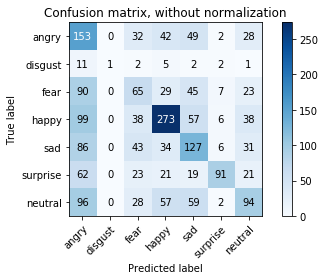

In [34]:
# 深度神经的 混淆矩阵
plot_confusion_matrix(test_label, dnn_cls, classes)

In [35]:
true_cls = pd.Series(test_label, name='true_cls')[test_label!=cnn_cls]

In [36]:
wrong_cls = pd.Series(cnn_cls, name='wrong_cls')[test_label!=cnn_cls]

In [37]:
wrong = pd.concat([true_cls, wrong_cls], axis = 1)
wrong

,true_cls,wrong_cls
1,0,2
2,0,4
3,0,6
4,6,4
5,0,2
6,6,4
8,2,4
10,0,2
11,3,6
12,0,3


In [38]:
sad_neu = wrong[wrong['true_cls']==4][wrong['wrong_cls']==6].index.tolist()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [39]:
sample = sad_neu[0:9]
sample

[181, 211, 231, 273, 294, 296, 315, 318, 326]

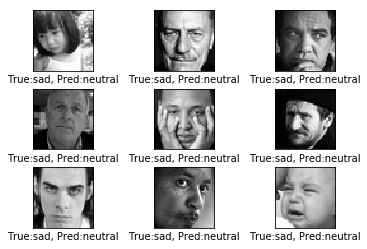

In [40]:
plot_images(test_x[sample], test_label[sample], cnn_cls[sample])

#### 5.4 可视化分析模型

#### 分析filter

第一部分将要视觉化每一个卷积层的weight以及图片在输入每一个卷积层后的输出,即经过filter后的值. 由于filter的数目过多, 每一个卷积层均取前64个filter, 每个filter都只取第一个channel

In [63]:
def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(8, 8)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

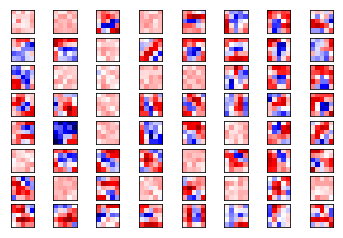

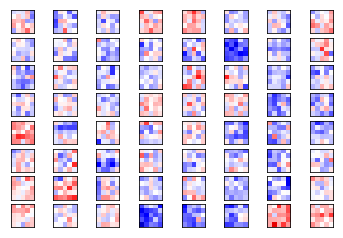

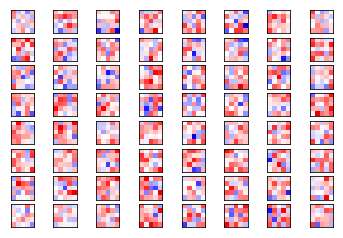

In [64]:
for conv_layer in conv_layers:
    plot_conv_weights(conv_layer.get_weights()[0])

#### 分析layer

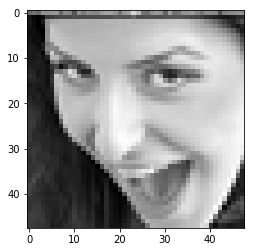

In [55]:
from tensorflow.keras import backend as K
image = test_x[0]
plt.imshow(image.reshape(48,48), cmap='gray')

In [56]:
def plot_conv_output(values):
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(8, 8)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='Blues')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [57]:
layer_input = cnn.layers[0]
layer_conv1 = cnn.layers[1]
layer_conv2 = cnn.layers[5]
layer_conv3 = cnn.layers[9]
conv_layers = [layer_conv1, layer_conv2, layer_conv3]
layer_conv1.get_weights()[0].shape

(5, 5, 1, 64)

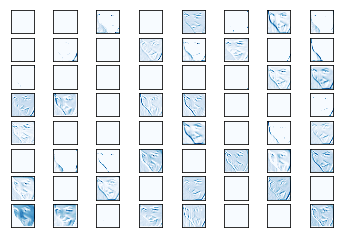

In [58]:
# 输出结果
output_conv1 = K.function(inputs=[layer_input.input],
                          outputs=[layer_conv1.output])
output_conv2 = K.function(inputs=[layer_input.input],
                          outputs=[layer_conv2.output])
output_conv3 = K.function(inputs=[layer_input.input],
                          outputs=[layer_conv3.output])

# output_conv1([[image]])[0]
layer_output1 = output_conv1([[image]])[0]
layer_output2 = output_conv2([[image]])[0]
layer_output3 = output_conv3([[image]])[0]
plot_conv_output(values=layer_output1)

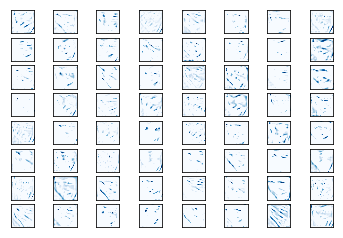

In [60]:
plot_conv_output(values=layer_output2)

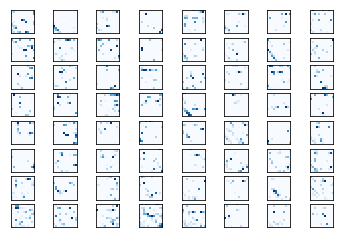

In [61]:
plot_conv_output(values=layer_output3)

#### 分析filter 和 layer

In [66]:
layer_outputs = [layer_output1,layer_output2,layer_output3]
conv_layers = [layer_conv1, layer_conv2, layer_conv3]


第1层权重值


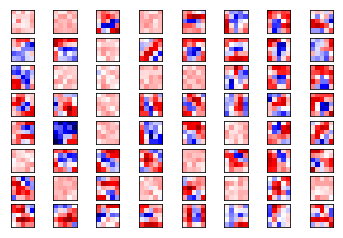

第1层输出值


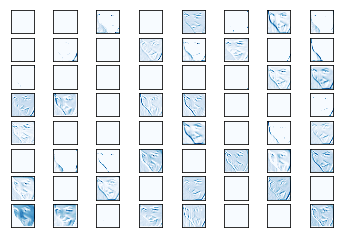

第2层权重值


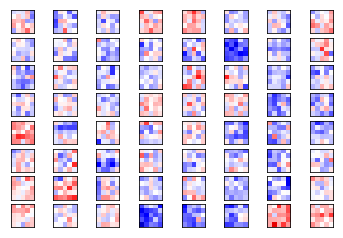

第2层输出值


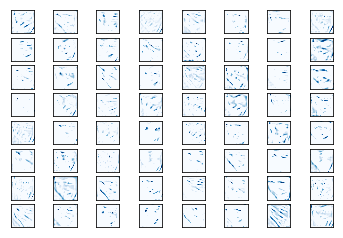

第3层权重值


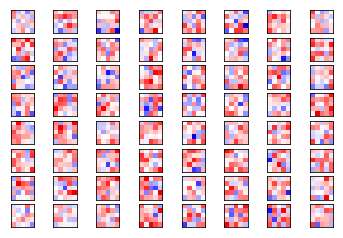

第3层输出值


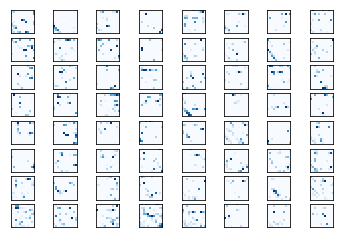

In [72]:
i = 1
for conv_layer,layer_output in zip(conv_layers,layer_outputs):
    print("第%s个卷积层权重值"%i)
    plot_conv_weights(conv_layer.get_weights()[0])
    print("第%s个卷积层输出值"%i)
    plot_conv_output(values=layer_output)
    i += 1

有上面可见随着经过更多的卷积层, 原始图片被拆分成的特征越来越不能被人类所识别, 但是简单从每一个filter的weight来分析并不能直观确定每一个filter具体做了什么

#### 使用gradient ascend来分析filter
其原理就是降输入的图片当作48*48维的变量, 通过梯度上升的方法, 在一定的循环次数后, 将某一卷积层中的经过某一filter之后reduce_mean的值不断增加, 从而通过输入的图片来了解这个filter关注与什么样的纹理构造, 这种分析方式也称做feature maximization or activation maximization

以下为每一卷积层前64个filter在做graident ascend的结果, step为0.1, 每个做了500次。

In [73]:
# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_conv1.output
filter_index = 0
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, layer_input.input)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([layer_input.input], [loss, grads])

In [74]:
# we start from a gray image with some noise
input_img_data = np.random.random((1, 48, 48, 1)) * 20 + 128.
# run gradient ascent for 20 steps
for i in range(500):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * 0.1

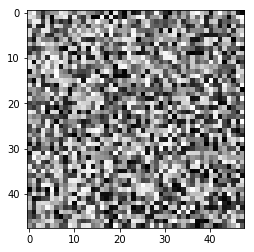

In [75]:
plt.imshow(input_img_data.reshape(48,48), cmap='gray')

In [76]:
def _filter(layer_conv):
    result = []
    layer_output = layer_conv.output
    for filter_index in range(64):
        loss = K.mean(layer_output[:, :, :, filter_index])
        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, layer_input.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([layer_input.input], [loss, grads])
        input_img_data = np.random.random((1, 48, 48, 1)) * 20 + 128.
        # run gradient ascent for 20 steps
        for i in range(500):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * 0.1
        result.append(input_img_data.reshape(48,48))
        
    return result

In [77]:
def plot_filter(layer_conv):
     # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(8, 8)
    img = _filter(layer_conv)
    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):

        ax.imshow(img[i], interpolation='nearest', cmap='Blues')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

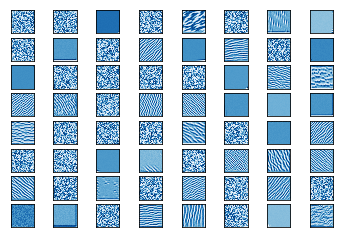

In [78]:
plot_filter(layer_conv1)

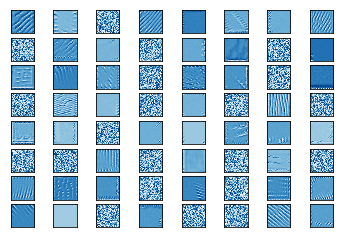

In [79]:
plot_filter(layer_conv2)

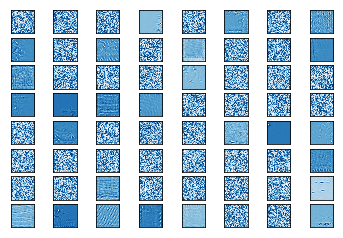

In [80]:
plot_filter(layer_conv3)

由此可见, 在开始的卷次层中每个filter的专注的目的比较明显, 可以看出明显的线条, 越往后filter提取的特征越为抽象